# Apply fid offsets in proseco

Reselect a set of catalogs in 2 aca drift model epochs (and in the interval since the last safe mode) to confirm new fid offset positions and verify proseco catalogs in general are reasonable with this change.

In [1]:
import os
os.environ['SKA'] = '/Users/jean/ska'
import sys
sys.path.insert(0, '/Users/jean/git/chandra_aca') # includes https://github.com/sot/chandra_aca/pull/157
sys.path.insert(0, '../') # Proseco with https://github.com/sot/proseco/pull/388
import chandra_aca
print(chandra_aca.__version__)
import proseco
print(proseco.__version__)

4.44.1.dev12+gb259754
5.11.1.dev33+g989143d


In [2]:
from IPython.display import display

from proseco.diff import catalog_diff


from functools import lru_cache
from pathlib import Path
import pickle
import gzip
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='chandra_aca')
warnings.filterwarnings('ignore', category=UserWarning, module='proseco')

import astropy.units as u
from astropy.table import Table, join, vstack
from cheta import fetch_sci as fetch

from cxotime import CxoTime
from ska_matplotlib import plot_cxctime
import matplotlib.pyplot as plt
import numpy as np

from kadi.commands import observations
from kadi.commands.commands_v2 import APPROVED_LOADS_OCCWEB_DIR
from kadi.occweb import get_occweb_page


In [3]:
# Retrieve fid stats data file on the web
COMMANDS_TELEM = Table.read(
    "https://cxc.harvard.edu/mta/ASPECT/ipynb/chandra_aca_fid_offset/fid_commands_telem.dat",
    format='ascii')

In [4]:
@lru_cache()
def get_pickle_path(load_name: str) -> Path:
    year = '20' + load_name[5:7]
    month_name = load_name[:3]
    pkl_path = (
        APPROVED_LOADS_OCCWEB_DIR 
        / year 
        / month_name 
        / load_name 
        / 'output'
        / f'{load_name}_proseco.pkl.gz'
        )
    return pkl_path

In [5]:
@lru_cache(maxsize=5)
def get_acas(load_name):
    path = get_pickle_path(load_name)
    pkl_bytes = get_occweb_page(path, binary=True, cache=True)
    acas = pickle.loads(gzip.decompress(pkl_bytes))
    return acas

In [6]:
def get_aca(obsid, load_name):
    acas = get_acas(load_name)
    return acas[obsid]

In [7]:
def reselect(aca, enable_fid=None):
    if enable_fid is None:
        if 'PROSECO_ENABLE_FID_OFFSET' in os.environ:
            del os.environ['PROSECO_ENABLE_FID_OFFSET']
    else:
        os.environ['PROSECO_ENABLE_FID_OFFSET'] = str(enable_fid)

    call_args = aca.call_args.copy()
    if 'dark_date' in aca.meta:
        call_args['dark_date'] = aca.meta['dark_date']
    new_aca = proseco.get_aca_catalog(**call_args)
        #print(acas[obsid].meta['dark_date'], new_acas[obsid].meta['dark_date'])
    return new_aca

In [8]:
def get_data(obss):
    seen_obs = {}
    dat = []
    for obs in obss:
        if int(obs['obsid']) > 38000:
            continue
        # Skip if we've already seen this obsid.
        # Since we're working from kadi.observations, this will also skip
        # obsids after SCS107.  That's fine.
        if obs['obsid'] in seen_obs:
            continue
        seen_obs[obs['obsid']] = 1
        if obs.get('starcat_date') is None:
            continue
        if obs['source'] == 'CMD_EVT':
            continue
        obsid = obs['obsid']
        #sc = observations.get_starcats(obsid=obs['obsid'], starcat_date=obs['starcat_date'])
        aca = get_aca(obsid, obs['source'])
        aca_fid_false = reselect(aca, enable_fid='False')
        aca_fid_true = reselect(aca, enable_fid='True')
        aca_fid_none = reselect(aca, enable_fid=None)
        fid_obs = COMMANDS_TELEM[COMMANDS_TELEM['obsid'] == obsid]
        for slot in fid_obs['slot']:
            row = {'aca_orig_yang': aca[aca['slot'] == slot]['yang'][0],
                'aca_orig_zang': aca[aca['slot'] == slot]['zang'][0],
                'aca_orig_id': aca[aca['slot'] == slot]['id'][0],
                'aca_fid_false_yang': aca_fid_false[aca_fid_false['slot'] == slot]['yang'][0],
                'aca_fid_false_zang': aca_fid_false[aca_fid_false['slot'] == slot]['zang'][0],
                    'aca_fid_false_id': aca_fid_false[aca_fid_false['slot'] == slot]['id'][0],
                    'aca_fid_true_yang': aca_fid_true[aca_fid_true['slot'] == slot]['yang'][0],
                    'aca_fid_true_zang': aca_fid_true[aca_fid_true['slot'] == slot]['zang'][0],
                    'aca_fid_true_id': aca_fid_true[aca_fid_true['slot'] == slot]['id'][0],
                    'aca_fid_none_yang': aca_fid_none[aca_fid_none['slot'] == slot]['yang'][0],
                    'aca_fid_none_zang': aca_fid_none[aca_fid_none['slot'] == slot]['zang'][0],
                    'aca_fid_none_id': aca_fid_none[aca_fid_none['slot'] == slot]['id'][0],
                    'aca_obs_yang': fid_obs[fid_obs['slot'] == slot]['aoacyan'][0],
                    'aca_obs_zang': fid_obs[fid_obs['slot'] == slot]['aoaczan'][0],
                    'backstop_yang': fid_obs[fid_obs['slot'] == slot]['yang'][0],
                    'backstop_zang': fid_obs[fid_obs['slot'] == slot]['zang'][0],
                    'detector': fid_obs[fid_obs['slot'] == slot]['detector'][0],
                    'source': obs['source'],
                    'slot': slot,
                    'tstart': fid_obs[fid_obs['slot'] == slot]['tstart'][0],
                    'obsid': obsid}
            dat.append(row)
    return Table(dat)

In [9]:
def plot_hist_resid(dat):    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ybins = np.arange(-8, 40, 1)
    #ybins = None
    ax[0].hist(dat['aca_obs_yang'] - dat['aca_orig_yang'], bins=ybins,
               alpha=0.5, label='as run')
    ax[0].hist(dat['aca_obs_yang'] - dat['aca_fid_true_yang'], bins=ybins, 
               alpha=0.5, label='this PR')
    ax[0].set_xlabel('Y offset (arcsec)')
    ax[0].legend()
    ax[0].grid()
    zbins = np.arange(-8, 13, 1)
    ax[1].hist(dat['aca_obs_zang'] - dat['aca_orig_zang'], bins=zbins,
               alpha=0.5, label='as run')
    ax[1].hist(dat['aca_obs_zang'] - dat['aca_fid_true_zang'], bins=zbins,
               alpha=0.5, label='this PR')
    ax[1].set_xlabel('Z offset (arcsec)')
    ax[1].legend()
    ax[1].grid()
    plt.suptitle(f"fid position residuals"); 

In [10]:
def plot_time_resid(dat):    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plot_cxctime(dat['tstart'], dat['aca_obs_yang'] - dat['aca_orig_yang'], '.', label='as run', ax=ax[0])
    plot_cxctime(dat['tstart'], dat['aca_obs_yang'] - dat['aca_fid_true_yang'], '.', label='this PR', ax=ax[0])
    ax[0].set_ylabel('Y offset (arcsec)')
    ax[0].legend()
    ax[0].grid()
    plot_cxctime(dat['tstart'], dat['aca_obs_zang'] - dat['aca_orig_zang'], '.', label='as run', ax=ax[1])
    plot_cxctime(dat['tstart'], dat['aca_obs_zang'] - dat['aca_fid_true_zang'], '.', label='this PR', ax=ax[1])
    ax[1].set_ylabel('Z offset (arcsec)')
    ax[1].legend()
    ax[1].grid()
    plt.suptitle(f"fid position residuals"); 

In [11]:
def get_det_per_fid_counts(dat):
    det_per_fid = {}
    for det in ['HRC-I', 'HRC-S', 'ACIS-I', 'ACIS-S']:
        fid_counts = {}
        rows = dat[dat['detector'] == det]
        for id in [1, 2, 3, 4, 5, 6]:
            if det in ['HRC-I', 'HRC-S']:
                if id in [5, 6]:
                    continue
            fid_counts[id] = np.count_nonzero(rows['aca_fid_true_id'] == id)
        det_per_fid[det] = fid_counts
    return det_per_fid

In [12]:
epochs = [{'epoch': 1,
          'start': '2019:180',
          'stop': '2019:270',
          'note': 'after 2018:285 step change'},
          {'epoch': 2,
           'start': '2022:295',
           'stop': '2023:040',
           'note': 'after 2022:294 step change'},
          {'epoch': 3,
           'start': '2023:200',
           'stop': '2023:290',
           'note': 'after 2023:047 safe modes (not recalibrated)'},
           ]

epoch_dat = {}
for epoch in epochs:
    filename = f'fid_epoch{epoch["epoch"]}.csv'
    if Path(filename).exists():
        epoch_dat[epoch['epoch']] = Table.read(f'fid_epoch{epoch["epoch"]}.csv')
    else:
        obss = observations.get_observations(start=epoch['start'], stop=epoch['stop'])
        epoch_dat[epoch['epoch']] = get_data(obss)
        epoch_dat[epoch['epoch']].write(filename, format='ascii.csv')



In [13]:
def report(dat):
    changed = dat['aca_orig_id'] != dat['aca_fid_false_id']
    print("Number of data rows: ", len(dat))
    print("Number of fids changed with reselect: ", len(dat[changed]))
    y_match = np.all(dat['aca_fid_false_yang'][~changed] == dat['aca_orig_yang'][~changed])
    z_match = np.all(dat['aca_fid_false_zang'][~changed] == dat['aca_orig_zang'][~changed])
    print("Positions match for reselect fids with var set to false: ", y_match and z_match)
    y_match = np.all(dat['aca_fid_true_yang'][~changed] == dat['aca_fid_none_yang'][~changed])
    z_match = np.all(dat['aca_fid_true_zang'][~changed] == dat['aca_fid_none_zang'][~changed])
    print("Positions match for reselect fids with var set to none or true: ", y_match and z_match)
    ok = dat['aca_orig_id'] == dat['aca_fid_true_id']
    print("Number of fids changed with fid offset reselect: ", len(dat[~ok]))
    plot_hist_resid(dat[ok])
    plot_time_resid(dat[ok])
    print("Fids used by detector (confirm coverage)")
    print(get_det_per_fid_counts(dat[ok]))
    

### Confirm new proseco positions with the fid offsets applied are closer to observed fid light positions over three "epochs" and ~900 observations.

The first epoch in this notebook includes data in 2019 (after proseco came into use)
which is also after the 2018:265 jump.  The Y and Z fid offsets with the PR are approximately
zero-centered.

Number of data rows:  756
Number of fids changed with reselect:  18
Positions match for reselect fids with var set to false:  True
Positions match for reselect fids with var set to none or true:  True
Number of fids changed with fid offset reselect:  38


Fids used by detector (confirm coverage)
{'HRC-I': {1: 24, 2: 17, 3: 20, 4: 13}, 'HRC-S': {1: 12, 2: 9, 3: 12, 4: 3}, 'ACIS-I': {1: 84, 2: 12, 3: 29, 4: 7, 5: 77, 6: 71}, 'ACIS-S': {1: 11, 2: 93, 3: 9, 4: 103, 5: 99, 6: 13}}


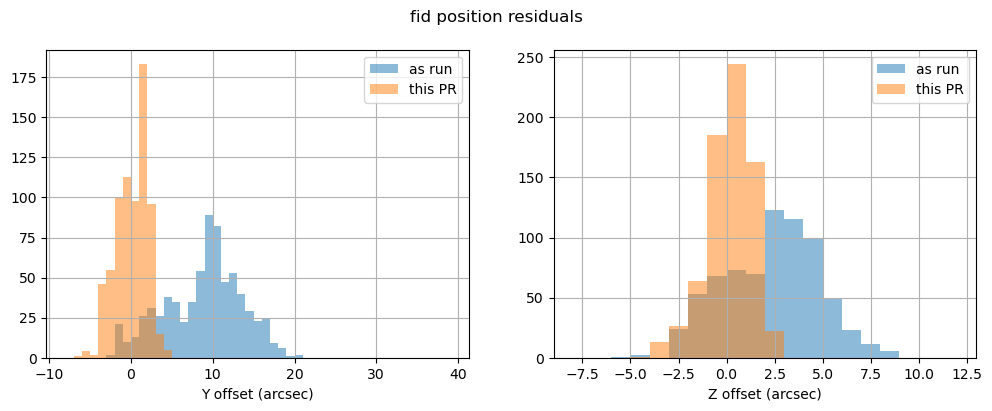

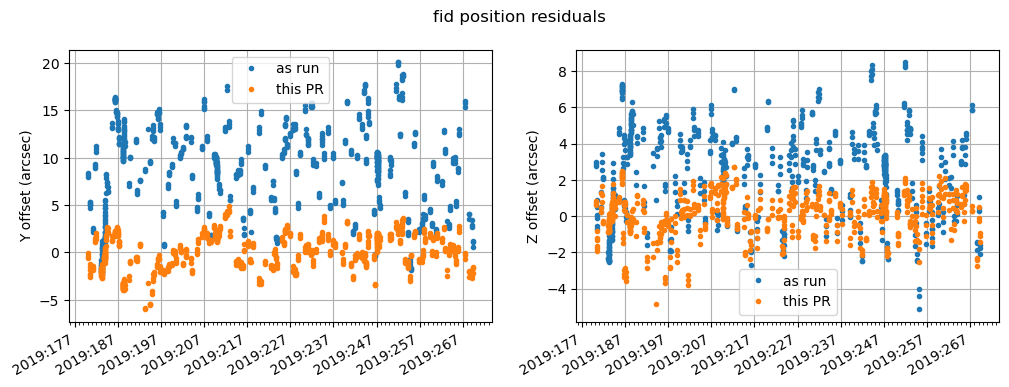

In [14]:
report(epoch_dat[1])

The second epoch in this notebook includes data in 2022 after the 2022:294 jump.  The new fid positions are approximately zero centered.

Number of data rows:  1205
Number of fids changed with reselect:  16
Positions match for reselect fids with var set to false:  True
Positions match for reselect fids with var set to none or true:  True
Number of fids changed with fid offset reselect:  68
Fids used by detector (confirm coverage)
{'HRC-I': {1: 0, 2: 0, 3: 0, 4: 0}, 'HRC-S': {1: 0, 2: 0, 3: 0, 4: 0}, 'ACIS-I': {1: 113, 2: 6, 3: 27, 4: 10, 5: 107, 6: 109}, 'ACIS-S': {1: 29, 2: 211, 3: 35, 4: 231, 5: 216, 6: 43}}


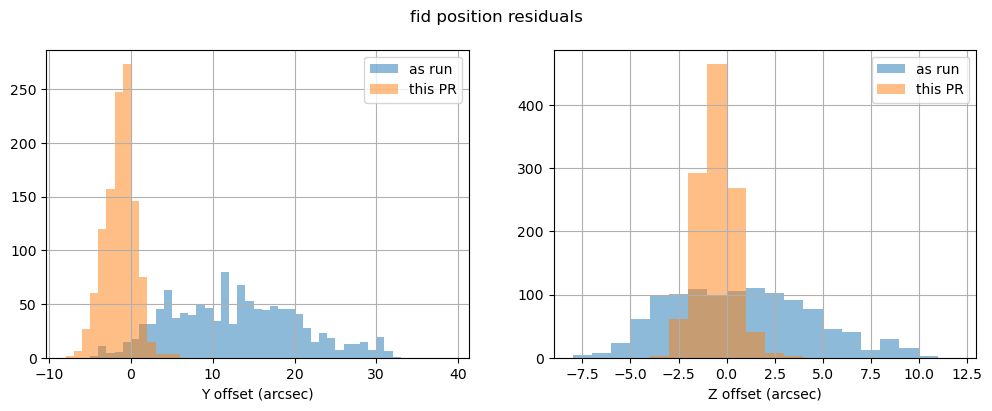

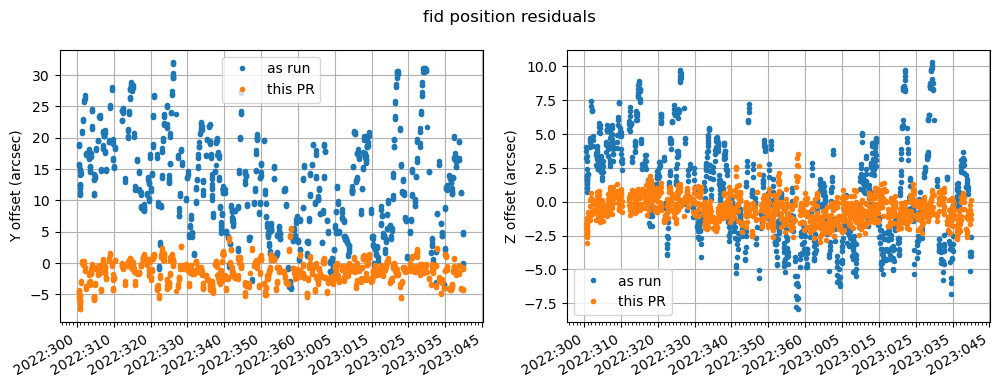

In [15]:
report(epoch_dat[2])

The third epoch is not an epoch as defined by the drift mode, but includes data after the 2023:044 2023:047 safe modes (the drift model has not been re-calibrated since jumps from those event).  The corrected fid positions show mean offsets but continue to show significantly reduce spread.

Number of data rows:  990
Number of fids changed with reselect:  1
Positions match for reselect fids with var set to false:  True
Positions match for reselect fids with var set to none or true:  True
Number of fids changed with fid offset reselect:  35
Fids used by detector (confirm coverage)
{'HRC-I': {1: 26, 2: 27, 3: 27, 4: 11}, 'HRC-S': {1: 21, 2: 18, 3: 21, 4: 8}, 'ACIS-I': {1: 88, 2: 6, 3: 36, 4: 8, 5: 96, 6: 98}, 'ACIS-S': {1: 26, 2: 124, 3: 16, 4: 130, 5: 126, 6: 42}}


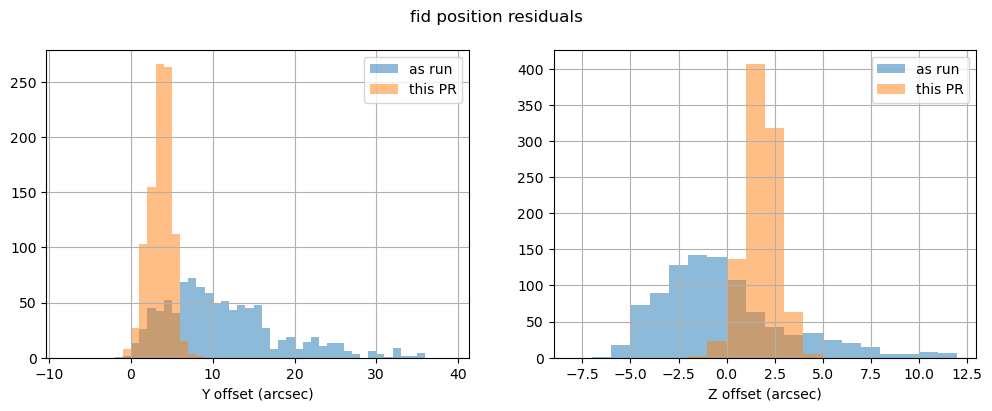

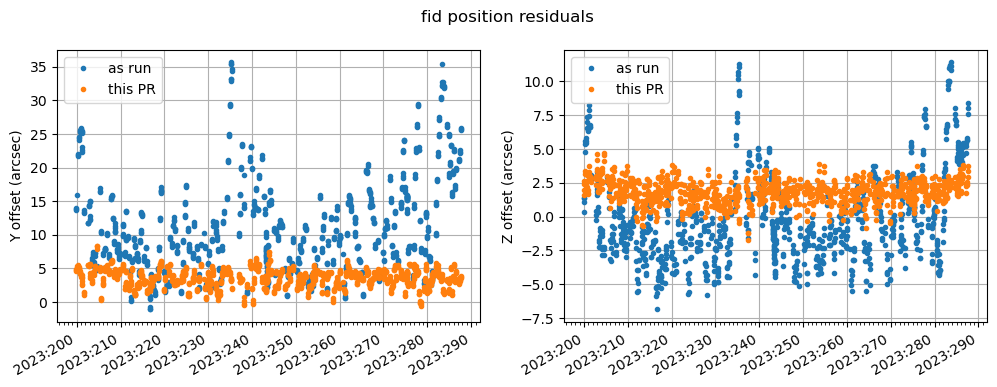

In [16]:
report(epoch_dat[3])

In [17]:
def get_diff_catalog(aca_new, aca_ref):    
    diff = catalog_diff(aca_ref, aca_new, 
                        names='idx id slot type yang zang',
                        labels=[f"Obsid {aca_new.obsid}"])
    return diff

In [18]:
from proseco.diff import CatalogDiff, HTML_FOOTER, HTML_HEADER

HTML_HEADER = """
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
"""

In [19]:
def get_criticals(aca):
    lines = []
    acar = aca.get_review_table()
    acar.run_aca_review()
    criticals = acar.messages >= "critical"
    if criticals:
        lines.append("-------------------------------")
        lines.append(f"{obsid}")
        lines.append("-------------------------------")
        for msg in criticals:
            lines.append(msg['category'].capitalize() + ': ' + msg['text'])
    return lines

In [20]:
import difflib
def get_diff_criticals(criticals_new, criticals_legacy):

    differ = difflib.HtmlDiff()
    text_diff = differ.make_table(criticals_legacy, criticals_new)

    return CatalogDiff(HTML_HEADER + "<H2>CRITICALS</H2>" + text_diff + "<HR></HR" + HTML_FOOTER, is_html=True)

In [21]:
def process_obsid(obsid, load_name):
    # get aca
    aca = get_aca(obsid, load_name)
    # get aca_fid_true
    aca_fid_true = reselect(aca, enable_fid='True')
    # get aca_fid_false
    aca_fid_false = reselect(aca, enable_fid='False')
    diff_catalog = get_diff_catalog(aca_fid_true, aca_fid_false)
    criticals_fid_true = get_criticals(aca_fid_true)
    criticals_fid_false= get_criticals(aca_fid_false)
    has_criticals = criticals_fid_true or criticals_fid_false
    diff_criticals = get_diff_criticals(criticals_fid_true, criticals_fid_false)
    has_diff_ids = (np.all(aca_fid_false['id'] == aca_fid_true['id']) &
                    len(aca_fid_true) == len(aca_fid_false))
    return diff_catalog, diff_criticals, has_criticals, has_diff_ids

In [22]:
# For all of the obsids in the samples
dat = vstack([epoch_dat[1], epoch_dat[2], epoch_dat[3]])
obsids = np.unique(dat['obsid'])
print(len(obsids))

985


### Confirm reselected catalogs with and without the fid position updates are still reasonable catalogs without critical errors.

In [23]:
obs_criticals = []
obs_diff_ids = []
for obsid in obsids:
    # get rows from dat to get source load name
    rows = dat[dat['obsid'] == obsid]
    diff_catalog, diff_criticals, has_criticals, has_diff_ids = process_obsid(obsid, rows['source'][0])
    if has_criticals:
        obs_criticals.append((obsid, rows['source'][0]))
        display(diff_catalog)
        display(diff_criticals)
    if has_diff_ids:
        obs_diff_ids.append((obsid, rows['source'][0]))
        break
    

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- --------- ---- ---- -------- --------,,2,--- --------- ---- ---- -------- --------
t,3,1 1 0 FID 919.83 -844.17,t,3,1 1 0 FID 934.86 -839.01
,4,2 5 1 FID -1828.23 1053.81,,4,2 5 1 FID -1813.19 1058.98
,5,3 6 2 FID 385.81 1697.85,,5,3 6 2 FID 400.85 1703.02
,6,--- --------- ---- ---- -------- --------,,6,--- --------- ---- ---- -------- --------
,7,5 548932512 4 GU* 145.33 1635.81,,7,5 548932512 4 GU* 145.33 1635.81
,8,4 548933960 3 GU* 977.82 -1527.82,,8,4 548933960 3 GU* 977.82 -1527.82
,9,7 548937184 6 GU* -393.18 -599.46,,9,7 548937184 6 GU* -393.18 -599.46
,10,6 549850840 5 GU* -2220.93 2113.50,,10,6 549850840 5 GU* -2220.93 2113.50
,11,--- --------- ---- ---- -------- --------,,11,--- --------- ---- ---- -------- --------


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to361__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next"><a href="#difflib_chg_to361__top">t</a></td><td class="diff_header" id="from361_1">1</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"><a href="#difflib_chg_to361__top">t</a></td><td class="diff_header" id="to361_1">1</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from361_2">2</td><td nowrap="nowrap">22200</td><td class="diff_next"></td><td class="diff_header" id="to361_2">2</td><td nowrap="nowrap">22200</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from361_3">3</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"></td><td class="diff_header" id="to361_3">3</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from361_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.93&nbsp;&lt;&nbsp;4.0</td><td class="diff_next"></td><td class="diff_header" id="to361_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.93&nbsp;&lt;&nbsp;4.0</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from361_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.93&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td><td class="diff_next"></td><td class="diff_header" id="to361_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.93&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- --------- ---- ---- -------- --------,,2,--- --------- ---- ---- -------- --------
t,3,1 1 0 FID 919.83 -844.17,t,3,1 1 0 FID 928.36 -842.04
,4,2 5 1 FID -1828.23 1053.81,,4,2 5 1 FID -1819.70 1055.95
,5,3 6 2 FID 385.81 1697.85,,5,3 6 2 FID 394.34 1699.99
,6,--- --------- ---- ---- -------- --------,,6,--- --------- ---- ---- -------- --------
,7,5 548932512 4 GU* 126.21 1636.91,,7,5 548932512 4 GU* 126.21 1636.91
,8,4 548933960 3 GU* 996.12 -1516.64,,8,4 548933960 3 GU* 996.12 -1516.64
,9,7 548937184 6 GU* -385.77 -604.58,,9,7 548937184 6 GU* -385.77 -604.58
,10,6 549850840 5 GU* -2245.53 2086.54,,10,6 549850840 5 GU* -2245.53 2086.54
,11,--- --------- ---- ---- -------- --------,,11,--- --------- ---- ---- -------- --------


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to365__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next"><a href="#difflib_chg_to365__top">t</a></td><td class="diff_header" id="from365_1">1</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"><a href="#difflib_chg_to365__top">t</a></td><td class="diff_header" id="to365_1">1</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from365_2">2</td><td nowrap="nowrap">22264</td><td class="diff_next"></td><td class="diff_header" id="to365_2">2</td><td nowrap="nowrap">22264</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from365_3">3</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"></td><td class="diff_header" id="to365_3">3</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from365_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.98&nbsp;&lt;&nbsp;4.0</td><td class="diff_next"></td><td class="diff_header" id="to365_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.98&nbsp;&lt;&nbsp;4.0</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from365_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.98&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td><td class="diff_next"></td><td class="diff_header" id="to365_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.98&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- --------- ---- ---- -------- --------,,2,--- --------- ---- ---- -------- --------
t,3,1 1 0 FID 919.83 -844.17,t,3,1 1 0 FID 929.01 -841.73
,4,2 5 1 FID -1828.23 1053.81,,4,2 5 1 FID -1819.04 1056.26
,5,3 6 2 FID 385.81 1697.85,,5,3 6 2 FID 395.00 1700.29
,6,--- --------- ---- ---- -------- --------,,6,--- --------- ---- ---- -------- --------
,7,5 548932512 4 GU* 125.33 1636.50,,7,5 548932512 4 GU* 125.33 1636.50
,8,4 548933960 3 GU* 995.24 -1517.05,,8,4 548933960 3 GU* 995.24 -1517.05
,9,7 548937184 6 GU* -386.65 -604.99,,9,7 548937184 6 GU* -386.65 -604.99
,10,6 549850840 5 GU* -2246.41 2086.13,,10,6 549850840 5 GU* -2246.41 2086.13
,11,--- --------- ---- ---- -------- --------,,11,--- --------- ---- ---- -------- --------


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to367__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next"><a href="#difflib_chg_to367__top">t</a></td><td class="diff_header" id="from367_1">1</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"><a href="#difflib_chg_to367__top">t</a></td><td class="diff_header" id="to367_1">1</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from367_2">2</td><td nowrap="nowrap">22265</td><td class="diff_next"></td><td class="diff_header" id="to367_2">2</td><td nowrap="nowrap">22265</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from367_3">3</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"></td><td class="diff_header" id="to367_3">3</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from367_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.89&nbsp;&lt;&nbsp;4.0</td><td class="diff_next"></td><td class="diff_header" id="to367_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.89&nbsp;&lt;&nbsp;4.0</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from367_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.89&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td><td class="diff_next"></td><td class="diff_header" id="to367_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.89&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- --------- ---- ---- -------- --------,,2,--- --------- ---- ---- -------- --------
t,3,1 1 0 FID 919.83 -844.17,t,3,1 1 0 FID 931.11 -840.80
,4,2 5 1 FID -1828.23 1053.81,,4,2 5 1 FID -1816.94 1057.18
,5,3 6 2 FID 385.81 1697.85,,5,3 6 2 FID 397.10 1701.22
,6,--- --------- ---- ---- -------- --------,,6,--- --------- ---- ---- -------- --------
,7,4 548933960 3 GU* -477.93 -1808.92,,7,4 548933960 3 GU* -477.93 -1808.92
,8,7 548937184 6 GU* -838.41 -192.92,,8,7 548937184 6 GU* -838.41 -192.92
,9,5 549849072 4 GU* -1547.46 2204.33,,9,5 549849072 4 GU* -1547.46 2204.33
,10,6 549849656 5 GU* 2453.57 2352.78,,10,6 549849656 5 GU* 2453.57 2352.78
,11,--- --------- ---- ---- -------- --------,,11,--- --------- ---- ---- -------- --------


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to467__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next"><a href="#difflib_chg_to467__top">t</a></td><td class="diff_header" id="from467_1">1</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"><a href="#difflib_chg_to467__top">t</a></td><td class="diff_header" id="to467_1">1</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from467_2">2</td><td nowrap="nowrap">22733</td><td class="diff_next"></td><td class="diff_header" id="to467_2">2</td><td nowrap="nowrap">22733</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from467_3">3</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"></td><td class="diff_header" id="to467_3">3</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from467_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.90&nbsp;&lt;&nbsp;4.0</td><td class="diff_next"></td><td class="diff_header" id="to467_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.90&nbsp;&lt;&nbsp;4.0</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from467_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.90&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td><td class="diff_next"></td><td class="diff_header" id="to467_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.90&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- --------- ---- ---- -------- --------,,2,--- --------- ---- ---- -------- --------
t,3,1 1 0 FID 919.83 -844.17,t,3,1 1 0 FID 929.02 -841.78
,4,2 5 1 FID -1828.23 1053.81,,4,2 5 1 FID -1819.03 1056.20
,5,3 6 2 FID 385.81 1697.85,,5,3 6 2 FID 395.00 1700.24
,6,--- --------- ---- ---- -------- --------,,6,--- --------- ---- ---- -------- --------
,7,4 548933960 3 GU* -479.60 -1809.71,,7,4 548933960 3 GU* -479.60 -1809.71
,8,7 548937184 6 GU* -840.08 -193.71,,8,7 548937184 6 GU* -840.08 -193.71
,9,5 549849072 4 GU* -1549.13 2203.54,,9,5 549849072 4 GU* -1549.13 2203.54
,10,6 549849656 5 GU* 2451.90 2351.99,,10,6 549849656 5 GU* 2451.90 2351.99
,11,--- --------- ---- ---- -------- --------,,11,--- --------- ---- ---- -------- --------


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to469__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next"><a href="#difflib_chg_to469__top">t</a></td><td class="diff_header" id="from469_1">1</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"><a href="#difflib_chg_to469__top">t</a></td><td class="diff_header" id="to469_1">1</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from469_2">2</td><td nowrap="nowrap">22734</td><td class="diff_next"></td><td class="diff_header" id="to469_2">2</td><td nowrap="nowrap">22734</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from469_3">3</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"></td><td class="diff_header" id="to469_3">3</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from469_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.89&nbsp;&lt;&nbsp;4.0</td><td class="diff_next"></td><td class="diff_header" id="to469_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.89&nbsp;&lt;&nbsp;4.0</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from469_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.89&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td><td class="diff_next"></td><td class="diff_header" id="to469_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.89&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- --------- ---- ---- -------- --------,,2,--- --------- ---- ---- -------- --------
t,3,1 2 0 FID -773.20 -1742.03,t,3,1 2 0 FID -770.80 -1742.84
,4,2 4 1 FID 2140.23 166.63,,4,2 4 1 FID 2142.63 165.82
,5,3 5 2 FID -1826.28 160.17,,5,3 5 2 FID -1823.88 159.36
,6,--- --------- ---- ---- -------- --------,,6,--- --------- ---- ---- -------- --------
,7,5 763889856 4 GU* -2034.26 1827.49,,7,5 763889856 4 GU* -2034.26 1827.49
,8,4 764808424 3 GU* 1641.26 2366.44,,8,4 764808424 3 GU* 1641.26 2366.44
,9,6 839255272 5 GU* 1254.94 302.86,,9,6 839255272 5 GU* 1254.94 302.86
,10,7 839262008 6 GU* -677.51 381.34,,10,7 839262008 6 GU* -677.51 381.34
,11,8 839262176 7 GU* -596.76 770.31,,11,8 839262176 7 GU* -596.76 770.31


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to499__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next"><a href="#difflib_chg_to499__top">t</a></td><td class="diff_header" id="from499_1">1</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"><a href="#difflib_chg_to499__top">t</a></td><td class="diff_header" id="to499_1">1</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from499_2">2</td><td nowrap="nowrap">22850</td><td class="diff_next"></td><td class="diff_header" id="to499_2">2</td><td nowrap="nowrap">22850</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from499_3">3</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"></td><td class="diff_header" id="to499_3">3</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from499_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.92&nbsp;&lt;&nbsp;4.0</td><td class="diff_next"></td><td class="diff_header" id="to499_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.92&nbsp;&lt;&nbsp;4.0</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from499_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.92&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td><td class="diff_next"></td><td class="diff_header" id="to499_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.92&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- --------- ---- ---- -------- --------,,2,--- --------- ---- ---- -------- --------
t,3,1 2 0 FID -773.20 -1742.03,t,3,1 2 0 FID -767.07 -1741.10
,4,2 4 1 FID 2140.23 166.63,,4,2 4 1 FID 2146.36 167.57
,5,3 5 2 FID -1826.28 160.17,,5,3 5 2 FID -1820.14 161.11
,6,--- --------- ---- ---- -------- --------,,6,--- --------- ---- ---- -------- --------
,7,4 763889856 3 GU* -2285.16 1477.35,,7,4 763889856 3 GU* -2285.16 1477.35
,8,8 764811080 7 GU* 1999.93 2390.30,,8,8 764811080 7 GU* 1999.93 2390.30
,9,5 839255272 4 GU* 1202.02 486.03,,9,5 839255272 4 GU* 1202.02 486.03
,10,6 839262008 5 GU* -718.91 261.23,,10,6 839262008 5 GU* -718.91 261.23
,11,7 839262176 6 GU* -700.00 658.05,,11,7 839262176 6 GU* -700.00 658.05


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to501__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next"><a href="#difflib_chg_to501__top">t</a></td><td class="diff_header" id="from501_1">1</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"><a href="#difflib_chg_to501__top">t</a></td><td class="diff_header" id="to501_1">1</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from501_2">2</td><td nowrap="nowrap">22851</td><td class="diff_next"></td><td class="diff_header" id="to501_2">2</td><td nowrap="nowrap">22851</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from501_3">3</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"></td><td class="diff_header" id="to501_3">3</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from501_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.48&nbsp;&lt;&nbsp;4.0</td><td class="diff_next"></td><td class="diff_header" id="to501_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.48&nbsp;&lt;&nbsp;4.0</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from501_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.48&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td><td class="diff_next"></td><td class="diff_header" id="to501_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.48&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- ---------- ---- ---- -------- --------,,2,--- ---------- ---- ---- -------- --------
t,3,1 1 0 FID 919.83 -844.17,t,3,1 1 0 FID 925.94 -846.90
,4,2 3 1 FID 37.19 -977.24,,4,2 3 1 FID 43.30 -979.96
,5,3 5 2 FID -1828.23 1053.81,,5,3 5 2 FID -1822.11 1051.09
,6,--- ---------- ---- ---- -------- --------,,6,--- ---------- ---- ---- -------- --------
,7,6 1055263328 5 GU* 1588.90 1144.43,,7,6 1055263328 5 GU* 1588.90 1144.43
,8,8 1055266912 7 GU* -496.02 1828.28,,8,8 1055266912 7 GU* -496.02 1828.28
,9,5 1055267536 4 GU* 869.07 865.93,,9,5 1055267536 4 GU* 869.07 865.93
,10,4 1055268728 3 GU* 186.48 1560.21,,10,4 1055268728 3 GU* 186.48 1560.21
,11,7 1056183096 6 GU* -509.58 -1118.72,,11,7 1056183096 6 GU* -509.58 -1118.72


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to1315__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next"><a href="#difflib_chg_to1315__top">t</a></td><td class="diff_header" id="from1315_1">1</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"><a href="#difflib_chg_to1315__top">t</a></td><td class="diff_header" id="to1315_1">1</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from1315_2">2</td><td nowrap="nowrap">27394</td><td class="diff_next"></td><td class="diff_header" id="to1315_2">2</td><td nowrap="nowrap">27394</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from1315_3">3</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"></td><td class="diff_header" id="to1315_3">3</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from1315_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.18&nbsp;&lt;&nbsp;4.0</td><td class="diff_next"></td><td class="diff_header" id="to1315_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.18&nbsp;&lt;&nbsp;4.0</td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- --------- ---- ---- -------- --------,,2,--- --------- ---- ---- -------- --------
t,3,1 2 0 FID -773.20 -1742.03,t,3,1 1 0 FID 950.83 -1729.97
,4,2 4 1 FID 2140.23 166.63,,4,2 2 1 FID -744.96 -1734.11
,5,3 6 2 FID 388.59 803.75,,5,3 6 2 FID 416.83 811.68
,6,--- --------- ---- ---- -------- --------,,6,--- --------- ---- ---- -------- --------
,7,7 768606952 6 GU* -1332.39 -857.30,,7,7 768606952 6 GU* -1332.39 -857.30
,8,6 768607024 5 GU* -1509.06 -1022.63,,8,6 768607024 5 GU* -1509.06 -1022.63
,9,4 768613752 3 GU* -1984.37 1326.36,,9,4 768613752 3 GU* -1984.37 1326.36
,10,5 768737456 4 GU* 417.81 -2270.29,,10,5 768737456 4 GU* 417.81 -2270.29
,11,--- --------- ---- ---- -------- --------,,11,--- --------- ---- ---- -------- --------


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to1327__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next"><a href="#difflib_chg_to1327__top">t</a></td><td class="diff_header" id="from1327_1">1</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"><a href="#difflib_chg_to1327__top">t</a></td><td class="diff_header" id="to1327_1">1</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from1327_2">2</td><td nowrap="nowrap">27477</td><td class="diff_next"></td><td class="diff_header" id="to1327_2">2</td><td nowrap="nowrap">27477</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from1327_3">3</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"></td><td class="diff_header" id="to1327_3">3</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from1327_4">4</td><td nowrap="nowrap">Critical:&nbsp;Guide&nbsp;indexes&nbsp;[6,&nbsp;7]&nbsp;clustered&nbsp;within&nbsp;500"&nbsp;radius&nbsp;(man_angle_next&nbsp;&gt;&nbsp;5.0)</td><td class="diff_next"></td><td class="diff_header" id="to1327_4">4</td><td nowrap="nowrap">Critical:&nbsp;Guide&nbsp;indexes&nbsp;[6,&nbsp;7]&nbsp;clustered&nbsp;within&nbsp;500"&nbsp;radius&nbsp;(man_angle_next&nbsp;&gt;&nbsp;5.0)</td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- ---------- ---- ---- -------- --------,,2,--- ---------- ---- ---- -------- --------
t,3,1 2 0 FID -773.20 -1742.03,t,3,1 2 0 FID -764.82 -1743.38
,4,2 4 1 FID 2140.23 166.63,,4,2 4 1 FID 2148.61 165.28
,5,3 5 2 FID -1826.28 160.17,,5,3 5 2 FID -1817.89 158.82
,6,--- ---------- ---- ---- -------- --------,,6,--- ---------- ---- ---- -------- --------
,7,4 1154352872 3 GU* -649.78 -2113.27,,7,4 1154352872 3 GU* -649.78 -2113.27
,8,5 1154483104 4 GU* 1103.76 -701.87,,8,5 1154483104 4 GU* 1103.76 -701.87
,9,7 1154483776 6 GU* -1221.11 11.10,,9,7 1154483776 6 GU* -1221.11 11.10
,10,6 1154486312 5 GU* -1466.68 2142.77,,10,6 1154486312 5 GU* -1466.68 2142.77
,11,8 1154486424 7 GUI -1874.84 928.26,,11,8 1154486424 7 GUI -1874.84 928.26


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to1391__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next"><a href="#difflib_chg_to1391__top">t</a></td><td class="diff_header" id="from1391_1">1</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"><a href="#difflib_chg_to1391__top">t</a></td><td class="diff_header" id="to1391_1">1</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from1391_2">2</td><td nowrap="nowrap">27537</td><td class="diff_next"></td><td class="diff_header" id="to1391_2">2</td><td nowrap="nowrap">27537</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from1391_3">3</td><td nowrap="nowrap">-------------------------------</td><td class="diff_next"></td><td class="diff_header" id="to1391_3">3</td><td nowrap="nowrap">-------------------------------</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from1391_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.69&nbsp;&lt;&nbsp;4.0</td><td class="diff_next"></td><td class="diff_header" id="to1391_4">4</td><td nowrap="nowrap">Critical:&nbsp;OR&nbsp;count&nbsp;of&nbsp;guide&nbsp;stars&nbsp;3.69&nbsp;&lt;&nbsp;4.0</td></tr>
            <tr><td class="diff_next"></td><td class="diff_header" id="from1391_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.69&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td><td class="diff_next"></td><td class="diff_header" id="to1391_5">5</td><td nowrap="nowrap">Critical:&nbsp;guide_count&nbsp;3.69&nbsp;and&nbsp;dither&nbsp;&gt;&nbsp;4x4&nbsp;arcsec</td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

f,1,idx id slot type yang zang,f,1,idx id slot type yang zang
,2,--- ---------- ---- ---- -------- --------,,2,--- ---------- ---- ---- -------- --------
t,3,1 1 0 FID -1175.03 -468.23,t,3,1 1 0 FID -1156.85 -465.28
,4,2 3 1 FID -1177.69 561.30,,4,2 2 1 FID 1242.89 -457.98
,5,3 4 2 FID 1223.32 563.70,,5,3 3 2 FID -1159.51 564.25
,6,--- ---------- ---- ---- -------- --------,,6,--- ---------- ---- ---- -------- --------
,7,8 1032066000 7 GU* -1400.85 -1938.60,,7,8 1032066000 7 GU* -1400.85 -1938.60
,8,4 1033781448 3 GU* -1722.02 -323.05,,8,4 1033781448 3 GU* -1722.02 -323.05
,9,5 1034300880 4 GU* 522.18 -208.24,,9,5 1034300880 4 GU* 522.18 -208.24
,10,7 1034314520 6 GU* 2095.28 -491.05,,10,7 1034314520 6 GU* 2095.28 -491.05
,11,6 1034323016 5 GU* 1015.18 -1108.98,,11,6 1034323016 5 GU* 1015.18 -1108.98


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
          "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html>
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=utf-8" />
    <title></title>
    <style type="text/css">
        table.diff {font-family:Courier; border:medium;}
        table.diff td {padding-top: 0em; padding-bottom: 0em;
                       padding-right: 0.5em; padding-left: 0.5em}
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
        td { text-align: left; }
    </style>
</head>
<body>
<H2>CRITICALS</H2>
    <table class="diff" id="difflib_chg_to1769__top"
           cellspacing="0" cellpadding="0" rules="groups" >
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        <colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
        
        <tbody>
            <tr><td class="diff_next" id="difflib_chg_to1769__0"><a href="#difflib_chg_to1769__top">t</a></td><td class="diff_header"></td><td nowrap="nowrap"></td><td class="diff_next"><a href="#difflib_chg_to1769__top">t</a></td><td class="diff_header" id="to1769_1">1</td><td nowrap="nowrap"><span class="diff_add">-------------------------------</span></td></tr>
            <tr><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap"></td><td class="diff_next"></td><td class="diff_header" id="to1769_2">2</td><td nowrap="nowrap"><span class="diff_add">28048</span></td></tr>
            <tr><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap"></td><td class="diff_next"></td><td class="diff_header" id="to1769_3">3</td><td nowrap="nowrap"><span class="diff_add">-------------------------------</span></td></tr>
            <tr><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap"></td><td class="diff_next"></td><td class="diff_header" id="to1769_4">4</td><td nowrap="nowrap"><span class="diff_add">Critical:&nbsp;Fid&nbsp;2&nbsp;has&nbsp;red&nbsp;spoiler:&nbsp;star&nbsp;1034304216&nbsp;with&nbsp;mag&nbsp;10.56</span></td></tr>
        </tbody>
    </table><HR></HR
        <table class="diff" summary="Legends">
        <tr> <th colspan="2"> Legends </th> </tr>
        <tr> <td> <table border="" summary="Colors">
                      <tr><th> Colors </th> </tr>
                      <tr><td class="diff_add">&nbsp;Added&nbsp;</td></tr>
                      <tr><td class="diff_chg">Changed</td> </tr>
                      <tr><td class="diff_sub">Deleted</td> </tr>
                  </table></td>
             <td> <table border="" summary="Links">
                      <tr><th colspan="2"> Links </th> </tr>
                      <tr><td>(f)irst change</td> </tr>
                      <tr><td>(n)ext change</td> </tr>
                      <tr><td>(t)op</td> </tr>
                  </table></td> </tr>
    </table>
</body>

</html>

The catalog review shows unrelated critical warnings that did not change in guide stars, and one new critical warning on a fid light spoiler.  Acceptable.